<a href="https://colab.research.google.com/github/StetskoSergey/pida5_stetsko/blob/master/homework_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation, OPTICS
from sklearn.metrics import adjusted_rand_score, silhouette_score


In [0]:
data = pd.read_excel('geo.xlsx', delimiter=",", index_col=0, encoding='Windows-1251')
# Сгруппируем данные и добавим колонку Активность голосования
data = data.groupby(['x','y','comment_class']).size().reset_index(name='activities')

In [119]:
data.head()

,x,y,comment_class,activities
0,37.148813,55.976806,-1,1
1,37.154158,55.991606,-1,1
2,37.156817,55.984043,-1,1
3,37.182887,55.970403,-1,1
4,37.184566,55.989688,-1,1


In [0]:
# Функция списка Алгоритмов
def algorithms(n_clusters=2):
  return [
      AffinityPropagation(),
      KMeans(n_clusters=n_clusters),
      AgglomerativeClustering(n_clusters=n_clusters),
      DBSCAN(),
  ]

In [0]:
# Функция оценки точности Алгоритма и вывода в тайтл графика
def get_descr(algo_name, y, y_pred, X):
    if len(set(y_pred)) < 2:
      ss = 0
    else:
      ss = silhouette_score(X, y_pred)  
    
    return "{}\nARI {:.2f}\nSilhouette {:.2f}".format(
        algo_name,
        adjusted_rand_score(y, y_pred),
        ss
    )

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Делаем нормализацию данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['x','y']])
y = data['comment_class'] 

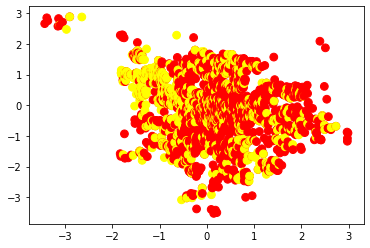

In [121]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c = y, cmap='autumn', s=60)

In [0]:
def result(algorithms, X_scaled, y):
    clusters_random = np.random.randint(low=0, high=2, size=len(X_scaled))
    fig, axes = plt.subplots(1, len(algorithms)+1, figsize=(15, 2))
    alpha = 0.3
    axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_random, cmap='autumn', s=60, alpha=alpha)
    axes[0].set_title(get_descr("Random", y, clusters_random, X_scaled))

    for ax, algorithm in zip(axes[1:], algorithms):
        # кластеризуем и выводим картинку
        clusters = algorithm.fit_predict(X_scaled)
        ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='autumn', s=60, alpha=alpha)
        ax.set_title(get_descr(algorithm.__class__.__name__, y, clusters, X_scaled))

        # если есть центры кластеров - выведем их
        if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
            centers = algorithm.cluster_centers_
            ax.scatter(centers[:, 0], centers[:, 1], s=50)

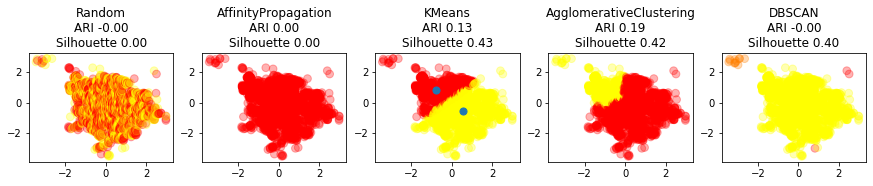

In [178]:
result(algorithms(), X_scaled, y)

Подбор количества кластеров для KMeans
KMeans минимизирует сумму квадратов расстояний объектов классов до их центроидов. В обученном классификаторе это значение находится в поле inertia_

Посчитаем значения inertia при разном количестве кластеров. Они объективно стремятся к нулю с ростом числа кластеров (предельный случай: каждый объект - кластер, расстояние = 0)

In [0]:
# Функция Рассчета оптимального кличества Кластеров
def inertia(X_scaled):
    k_inertia = []
    ks = range(1,11)

    for k in ks:
        clf_kmeans = KMeans(n_clusters=k)
        clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
        k_inertia.append(clf_kmeans.inertia_)
    plt.plot(ks, k_inertia)
    plt.plot(ks, k_inertia ,'ro')   
    diff = np.diff(k_inertia)
    plt.plot(ks[1:], diff)
    diff_r = diff[1:] / diff[:-1]
    plt.plot(ks[1:-1], diff_r)
    k_opt = ks[np.argmin(diff_r)+1]
    print('Опимальное количество сегментов ',k_opt)

Опимальное количество сегментов  2


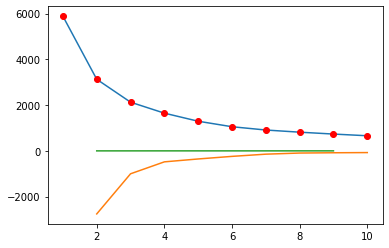

In [179]:
# Рассчет оптимального кличества Кластеров
inertia(X_scaled)

In [0]:
y_1 = data[data['comment_class']<0]['comment_class']
X_1 =  data[data['comment_class']<0][['x', 'y']]
y_2 = data[data['comment_class']>0]['comment_class']
X_2 =  data[data['comment_class']>0][['x', 'y']]

X_scaled_1 = StandardScaler().fit_transform(X_1)
X_scaled_2 = StandardScaler().fit_transform(X_2)

Опимальное количество сегментов  6
Опимальное количество сегментов  2


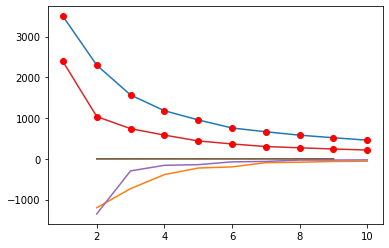

In [181]:
# Рассчет оптимального кличества Кластеров

inertia(X_scaled_1)
inertia(X_scaled_2)

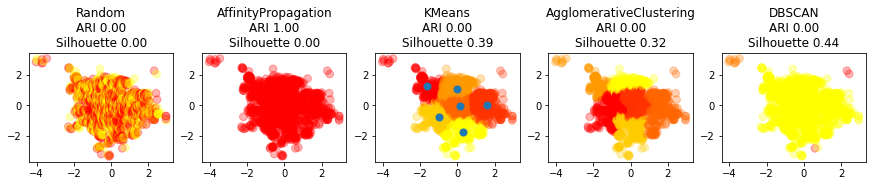

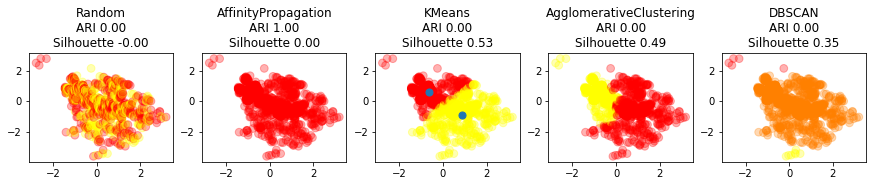

In [188]:
# Вывод кластеров районов с Отрицательным мнением - деление на 6 кластеров
result(algorithms(6), X_scaled_1, y_1)
# Вывод кластеров районов с Положительным мнением - деление на 2 кластера
result(algorithms(), X_scaled_2, y_2)

### найти наиболее активные в голосовании районы (подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')

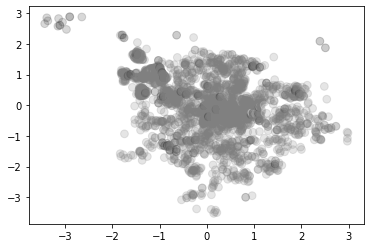

In [192]:
X_scaled = scaler.fit_transform(data[['x','y','activities']])
y = data['activities'] 
clusters = DBSCAN().fit_predict(X_scaled)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='gray', s=60, alpha=0.2)
